El objetivo de mi trabajo es determinar si la presencia y las características de hoteles o negocios cercanos a una propiedad de alquiler turístico tiene un impacto en los precios de alquiler.

Para llevar a cabo, he aunado datos de alquiler turístico de corta duración (AirBnB) en la ciudad de Berlín con datos de Foursquare sobre la ubicación y característica de locales de interés en la misma ciudad con datos de hoteles obtenidos en TripAdvisor (la API de Foursquare está en este html, el scraping de TripAdvisor y la transformación de las bases de datos de hoteles y alquileres en el HTML entrega II y el código de webcrawler en python para los hoteles en TripAdvisor un archivo separado). 



In [ ]:
# instalo los paquetes generales que voy utilizar

import sys
!{sys.executable} -m pip install geopandas==0.6.3
!{sys.executable} -m pip install mplleaflet
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pygeoj
!{sys.executable} -m pip install pyshp
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install --upgrade cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.4/920.4 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28582 sha256=52f885f496ac17d7f3ff2e9493f46dfa98516797ab981f8273ff690507bbf653
  Stored in directory: /root/.cache/pip/wheels/d4/a9/cf/8c4753b208759e9509ade040a94c3d4271f1756f529c575dc8
Successfully built mplleaflet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# para series temporales
!{sys.executable} -m pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# para analisis de vecindario
!{sys.executable} -m pip install descartes
!{sys.executable} -m pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# para análisis de accesibilidad 
# !!!!Cython tiene que estar actualizado antes!!!!!
!{sys.executable} -m pip install pandana

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 69.5 MB/s eta 0:00:00
  Attempting uninstall: tables
    Found existing installation: tables 3.7.0
    Uninstalling tables-3.7.0:
      Successfully uninstalled tables-3.7.0


In [ ]:
# para el modelado y el xboost
!{sys.executable} -m pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

# manipulación general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# análisis geográfico 
import geopandas as gpf #libspatialindex tiene que ser instalada antes
import json 
from pandas.io.json import json_normalize
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accesibilidad 
import time
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelado de datos (regresión)
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing 
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#ocultar warnings
import warnings
warnings.filterwarnings('ignore')

# preferencia plots como en R
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

print('Librerías importadas')

Librerías importadas


In [ ]:
pip install xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pwd para chequear si todo funciona 
raw_df = pd.read_csv('/content/datosdeusohotellisting.csv')
print(f"El dataset contiene {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # ver todas las columnas
pd.set_option('display.max_rows', 100)
raw_df.head(3)

El dataset contiene 102421 Airbnb listings


,Name,Latitude,Longitude,Providerprice1,cluster,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,884329,"Bed & Boat, apartment on houseboat. Free Parking.",4684314,Frans,NaN,De Aker - Nieuw Sloten,52.343079,4.788886,Private room,137,2,478,2022-08-21,4.09,1,239,37,0363 468F 67C1 8D65 D7C3
1,Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,947437,"Boutique room style ,room in quiet neighborhood",5134833,Andre,NaN,Osdorp,52.355950,4.796610,Private room,85,2,207,2022-09-05,1.89,2,299,23,0363 8300 75DC 8AD2 186A
2,Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,1100569,bright room + private roof terrace,5134833,Andre,NaN,Osdorp,52.356220,4.795440,Private room,80,2,155,2020-03-16,1.42,2,2,0,0363830075DC8AD2186A


In [ ]:
# Ahora empiezo con la API a foursquare 

CLIENT_ID = "TN5TVCGWYYAUSKIHBASFJW1DYKSIWE14OQDSJKOD2OXG2GXV"
CLIENT_SECRET = "ICVRSAJCMQBGYDW0CIPW2VR1SZCEQXSKRKGIISTO0L3IAJZZ"
VERSION = '20190425'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TN5TVCGWYYAUSKIHBASFJW1DYKSIWE14OQDSJKOD2OXG2GXV
CLIENT_SECRET:ICVRSAJCMQBGYDW0CIPW2VR1SZCEQXSKRKGIISTO0L3IAJZZ


In [ ]:
#cogemos los vecindarios por latitud y longitud y el neighbourhood a que pertenencen 
map_df = pd.DataFrame(columns=['latitude', 'longitude','neighbourhood'], data=raw_df[['latitude','longitude','neighbourhood']].values)
map_df.neighbourhood=map_df.neighbourhood.astype(str)
map_df.head()

,latitude,longitude,neighbourhood
0,52.343079,4.788886,De Aker - Nieuw Sloten
1,52.35595,4.79661,Osdorp
2,52.35622,4.79544,Osdorp
3,52.34255,4.80578,De Aker - Nieuw Sloten
4,52.38277,4.80351,Geuzenveld - Slotermeer


In [ ]:
# Función para hacer loops en todas venues y poder tener la información completa 
#url = 'https://api.foursquare.com/v2/venues/search?categoryId=50aa9e094b90af0d42d5de0d,530e33ccbcbc57f1066bbff3,530e33ccbcbc57f1066bbff9,4f2a25ac4b909258e854f55f&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format()
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    count = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
        # crear la request de la API - formato antiguo, ahora es con una key
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        try:
          # preparmo la request a través de GET
          results = requests.get(url).json()["response"]['groups'][0]['items']
          #print(results)

          # retorna solamente información relevante para las venues cerca
          venues_list.append([(
              name, 
              lat, 
              lng, 
              v['venue']['name'], 
              v['venue']['location']['lat'], 
              v['venue']['location']['lng'],  
              v['venue']['categories'][0]['name']) for v in results])
        except:
            pass
        count = count+1
        if count == 700:
            break
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Ahora pasamos esta función en todos los vecindarios y creamos un nuevo dataframe que se llamará localesberlin. Todavía falta aunar la BBDD trip advisor con AirBnB listings y foursquare.  

In [ ]:
localesberlin = getNearbyVenues(names=map_df['neighbourhood'],
                                   latitudes=map_df['latitude'],
                                   longitudes=map_df['longitude'],
                                   radius = 500
                                  )

In [ ]:
print(localesberlin.shape)
localesberlin.head()

(8009, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,De Aker - Nieuw Sloten,52.343079,4.788886,Molen van Sloten,52.341580,4.792271,Monument / Landmark
1,De Aker - Nieuw Sloten,52.343079,4.788886,De Patatza(a)k,52.341460,4.792530,Snack Place
2,De Aker - Nieuw Sloten,52.343079,4.788886,Speeltuin Sloten,52.341703,4.795679,Playground
3,De Aker - Nieuw Sloten,52.343079,4.788886,IJshoeve,52.341324,4.793758,Ice Cream Shop
4,De Aker - Nieuw Sloten,52.343079,4.788886,Syriana,52.341913,4.792768,Middle Eastern Restaurant


In [ ]:
# salvamos el dataset
localesberlin.to_csv(r'localesberlin.csv')

In [ ]:
# leyemos el dataset
localesberlin = pd.read_csv('/content/localesberlin.csv', index_col=0)

Agrupo los locales por vecindario

In [ ]:
localesberlin.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Buitenveldert - Zuidas,104,104,104,104,104,104
De Aker - Nieuw Sloten,3151,3151,3151,3151,3151,3151
Geuzenveld - Slotermeer,1597,1597,1597,1597,1597,1597
Osdorp,3073,3073,3073,3073,3073,3073
Slotervaart,84,84,84,84,84,84


Y busco categorías únicas (puede variar de acuerdo con el día que coja el código, aquí tenemos 141 categorías únicas)

In [ ]:
print('Hay {} categorías únicas.'.format(len(localesberlin['Venue Category'].unique())))

Hay 141 categorías únicas.


También agrupo los tipos de locales por vecindario para saber cuáles son más comunes y poder utilizar en nuestro análisis (aquí escojeré 10 pero en comparación en otro html solo cogeré 5).

In [ ]:
localesberlin.groupby('Venue Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Adult Boutique,9,9,9,9,9,9
Art Gallery,8,8,8,8,8,8
Arts & Crafts Store,21,21,21,21,21,21
Arts & Entertainment,4,4,4,4,4,4
Asian Restaurant,30,30,30,30,30,30
...,...,...,...,...,...,...
Vegetarian / Vegan Restaurant,20,20,20,20,20,20
Video Store,12,12,12,12,12,12
Water Park,53,53,53,53,53,53


Análisis por vecindario, haciendo one hot encoding para poder coger la regresión lineal

In [ ]:
# One Hot Encoding
berlin_onehot = pd.get_dummies(localesberlin[['Venue Category']], prefix = "", prefix_sep = "")

## Añadir la columna vecindario al df otra vez  
berlin_onehot['Neighbourhood'] = localesberlin['Neighbourhood']

# mover la columna vecindario a la primera
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

# display
berlin_onehot.head()

,Neighbourhood,Adult Boutique,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,...,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Water Park,Wine Shop,Women's Store
0,De Aker - Nieuw Sloten,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0
1,De Aker - Nieuw Sloten,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0
2,De Aker - Nieuw Sloten,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0
3,De Aker - Nieuw Sloten,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0
4,De Aker - Nieuw Sloten,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#dimensiones del df 
berlin_onehot.shape

(8009, 142)


Agrupamos por categorías y por la media y frecuencia de cada categoría en los vecindarios  

In [ ]:
berlintodos = berlin_onehot.groupby('Neighbourhood').mean().reset_index()
berlintodos

,Neighbourhood,Adult Boutique,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,...,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Water Park,Wine Shop,Women's Store
0,Buitenveldert - Zuidas,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.028846,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,De Aker - Nieuw Sloten,0.000000,0.002539,0.000000,0.000000,0.000000,0.017455,0.001269,0.001269,0.020628,0.000000,...,0.000000,0.000000,0.003174,0.000000,0.046334,0.000952,0.000000,0.003808,0.01682,0.003491,0.000000
2,Geuzenveld - Slotermeer,0.000000,0.000000,0.003757,0.002505,0.007514,0.035066,0.000000,0.000000,0.020038,0.015654,...,0.001879,0.000000,0.017533,0.015028,0.043832,0.031309,0.000000,0.000000,0.00000,0.000000,0.000000
3,Osdorp,0.002929,0.000000,0.004881,0.000000,0.005857,0.001952,0.000000,0.004556,0.045884,0.011715,...,0.006834,0.001302,0.000976,0.001952,0.022779,0.054344,0.006508,0.000000,0.00000,0.000000,0.001302
4,Slotervaart,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


coger cada vecindario con sus 10 categorías más frecuentes 

In [ ]:
num_top_venues = 10

for hood in berlintodos['Neighbourhood']:
    print("----"+hood+"----")
    temp = berlintodos[berlintodos['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Buitenveldert - Zuidas----
                  venue  freq
0       Harbor / Marina  0.29
1  Fast Food Restaurant  0.10
2         Boat or Ferry  0.10
3                 Diner  0.10
4                 Hotel  0.10
5              Creperie  0.10
6            Restaurant  0.06
7                  Café  0.06
8  Gym / Fitness Center  0.03
9              Bus Stop  0.03


----De Aker - Nieuw Sloten----
                  venue  freq
0           Supermarket  0.06
1           Snack Place  0.05
2          Tram Station  0.05
3            Restaurant  0.05
4              Bus Stop  0.05
5             Drugstore  0.04
6            Playground  0.04
7  Gym / Fitness Center  0.03
8    Chinese Restaurant  0.03
9            Hobby Shop  0.03


----Geuzenveld - Slotermeer----
                venue  freq
0            Bus Stop  0.06
1        Soccer Field  0.05
2                Park  0.04
3  Athletics & Sports  0.04
4        Tram Station  0.04
5  Turkish Restaurant  0.03
6              Garden  0.03
7          Campgro

metemos en datadframe para pandas

In [ ]:
# Función para retornar las categorías más comunes de mayor a menor
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
import numpy as np

# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = berlintodos['Neighbourhood']

for ind in np.arange(berlintodos.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlintodos.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Buitenveldert - Zuidas,Harbor / Marina,Fast Food Restaurant,Boat or Ferry,Diner,Hotel,Creperie,Restaurant,Café,Gym / Fitness Center,Bus Stop
1,De Aker - Nieuw Sloten,Supermarket,Bus Stop,Restaurant,Snack Place,Tram Station,Drugstore,Playground,Hotel,Gym / Fitness Center,Flower Shop
2,Geuzenveld - Slotermeer,Bus Stop,Soccer Field,Tram Station,Park,Athletics & Sports,Supermarket,Garden,Restaurant,Turkish Restaurant,Grocery Store
3,Osdorp,Supermarket,Turkish Restaurant,Snack Place,Bakery,Café,Park,Drugstore,Indonesian Restaurant,Gym,Bus Stop
4,Slotervaart,Harbor / Marina,Moroccan Restaurant,Martial Arts School,Bus Stop,Trail,Park,Paintball Field,Paper / Office Supplies Store,Outlet Mall,Other Repair Shop


Vamos ver cuáles son las caytegorías más comunes 

In [ ]:
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 3 unique categories.


In [ ]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

,Neighbourhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1st Most Common Venue,,,,,,,,,,
Bus Stop,1,1,1,1,1,1,1,1,1,1
Harbor / Marina,2,2,2,2,2,2,2,2,2,2
Supermarket,2,2,2,2,2,2,2,2,2,2


Podemos ver que la categoría más común es parada de autobus (si consideramos que no es relevante deberíamos elimnarla), seguida por marina y supermercado.  Si quisiéramos saber si un tipo de restaurante en concreto se relaciona con el precio de los locales (como de comida española) podríamos utilizar como subcategoría, pero hemos agregado. Luego aunaremos con los datos de hoteles para saber si hay impacto en los precios.

### 5. Preparando los datos

In [ ]:
# abrimos nuestros datos pre-procesados en entrega II
df = pd.read_csv(r'/content/datosdeusohotellisting.csv', index_col=0)
df.head()



,Latitude,Longitude,Providerprice1,cluster,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
Name,,,,,,,,,,,,,,,,,,,,,,
Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,884329,"Bed & Boat, apartment on houseboat. Free Parking.",4684314,Frans,NaN,De Aker - Nieuw Sloten,52.343079,4.788886,Private room,137,2,478,2022-08-21,4.09,1,239,37,0363 468F 67C1 8D65 D7C3
Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,947437,"Boutique room style ,room in quiet neighborhood",5134833,Andre,NaN,Osdorp,52.355950,4.796610,Private room,85,2,207,2022-09-05,1.89,2,299,23,0363 8300 75DC 8AD2 186A
Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,1100569,bright room + private roof terrace,5134833,Andre,NaN,Osdorp,52.356220,4.795440,Private room,80,2,155,2020-03-16,1.42,2,2,0,0363830075DC8AD2186A
Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,1408035,Family house in New-West Amsterdam.,2539835,Marie,NaN,De Aker - Nieuw Sloten,52.342550,4.805780,Shared room,50,3,38,2019-05-01,0.38,1,0,0,0363E200135D97823467
Hotel Adlon Kempinski Berlin,52.516117,13.380286,477.86,5,1427610,Spacious house in Amsterdam,7677579,Aukje,NaN,Geuzenveld - Slotermeer,52.382770,4.803510,Entire home/apt,100,5,5,2022-08-15,0.19,1,0,2,0363 316D 14AF 5201 F18F


In [ ]:
columns = ['host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'Providerprice1', 'cluster', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']
df = df[columns]

In [ ]:
cols_to_encode = []
for col in columns:
  if df[col].dtype == 'object':
    cols_to_encode.append(col)

In [ ]:
from sklearn.preprocessing import LabelEncoder
for col in cols_to_encode:
  le = LabelEncoder()
  df[col] = df[col].astype(str)
  df[col] = le.fit_transform(df[col])

Analizo si hay multicolinearidad entre las variables.

In [ ]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

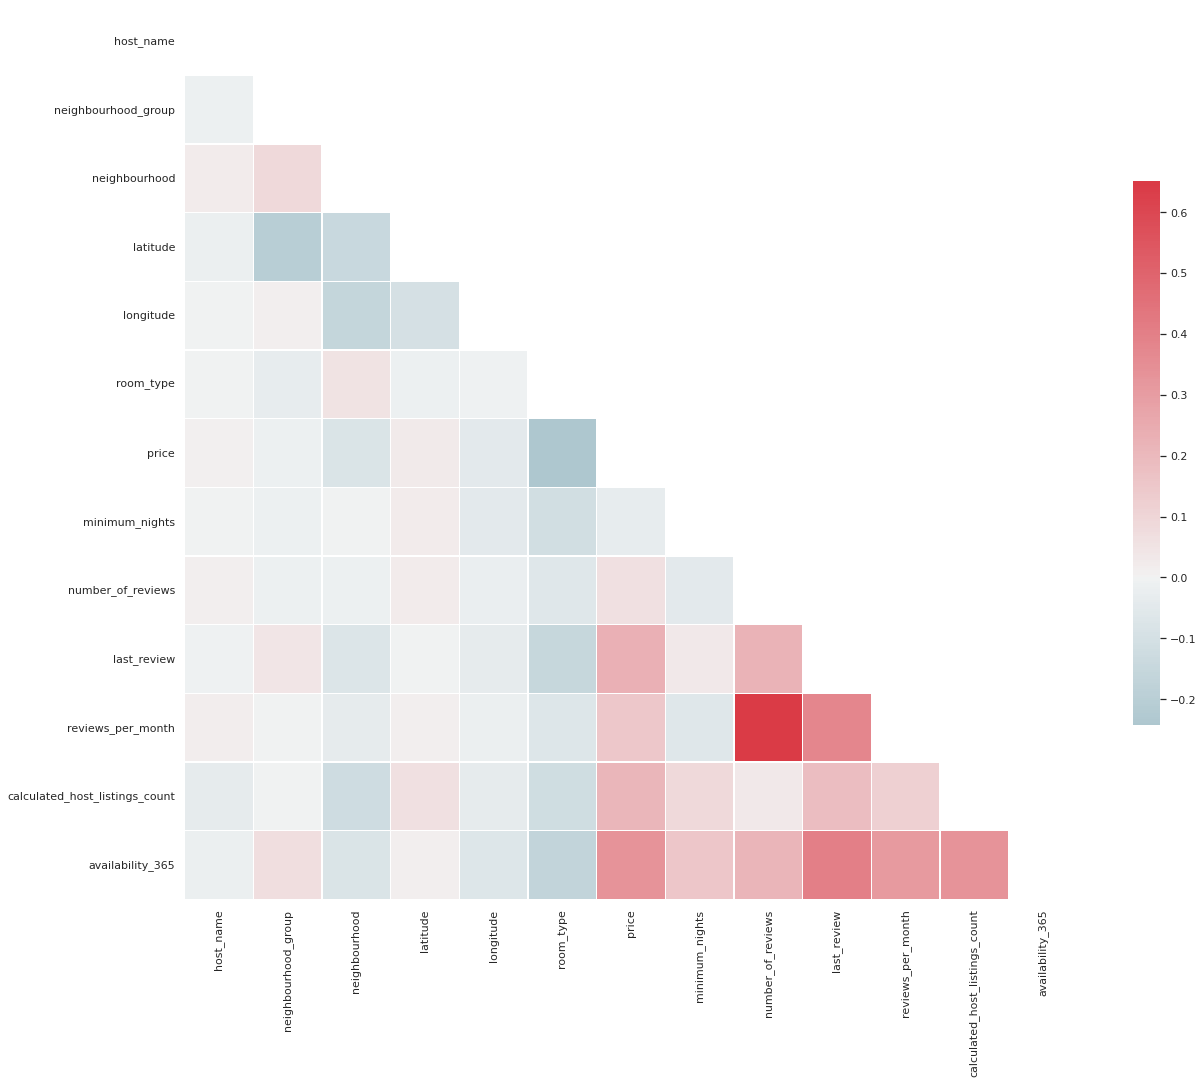

In [ ]:
multi_collinearity_heatmap(df, figsize=(20,20))

No hay colineralidad expresiva excepto la de num_reviews con reviews_per_month y last_review, pero no las voy eliminar.

In [ ]:
# Defino mi x como todas las variables menos el precio
# e y como el precio que es lo que queremos predecir
X = df.drop('price', axis=1)
y = df.price

# las meto en escala (normalizo)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X.fillna(0, inplace=True)

Modelos de aprendizaje supervisado

Ahora que el procesamiento previo de datos ha terminado, podemos comenzar a aplicar diferentes modelos de Aprendizaje automático supervisado. Compararemos dos modelos:

Un modelo de precios hedónicos espaciales (regresión OLS), con la regresión lineal de la biblioteca Scikit-Learn
El método Gradient Boosting, con XGBRegressor de la biblioteca XGBoost.

Las métricas de evaluación utilizadas serán error cuadrático medio (para pérdida) y r cuadrado (para precisión).

In [ ]:
# Separo entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

#### Modelo 1: Spatial Hedonic Price Model (HPM)

El modelo hedónico implica la regresión de los precios de venta observados en el listing en comparación con los atributos de una propiedad hipotética que determina el precio de venta. Proviene de la teoría hedónica de precios que supone que una mercancía, como una casa, puede verse como una agregación de componentes o atributos individuales (Griliches, 1971). Se supone que los consumidores compran bienes que incorporan paquetes de atributos que maximizan sus funciones de utilidad subyacentes (Rosen, 1974).

Además de las características de los listados de Airbnb, agregamos características de ubicación, ya que se ha demostrado que son factores importantes para influir en el precio. Idealmente, las pruebas de multiplicador de Lagrange deben realizarse para verificar si hay un retraso espacial en la variable dependiente y, por lo tanto, se prefiere un modelo de retraso espacial para estimar un HPM espacial. Sin embargo, para los fines de este modelo solo estamos utilizando un modelo OLS convencional para la estimación de precios hedónicos que incluye características espaciales y de ubicación, pero no un retraso espacial que explica la dependencia espacial.

Por lo tanto, las primeras variables explicativas son las características de los listados (tipo de habitación por ejemplo) y nuestro segundo grupo de variables explicativas basadas en características espaciales y de ubicación son Score, que es la distancia de red al quinto lugar más cercano que calculamos con Pandana; y Barrio perteneciente, 1 si el listado pertenece al barrio especificado, 0 en caso contrario. También la pertenencia al cluster para identificar la cercanía con locales cerca. 

In [ ]:
hpm_reg_start = time.time()

# Creo la función de la regresión lineal
# Ajusto el modelo a los datos

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #entreino

# Podemos hacer prediccionees a través del comando predict  
# las prediciones son en el test set
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.0 minutes

Training RMSE: 22505.1217
Validation RMSE: 17458.9535

Training r2: 0.1095
Validation r2: 0.1334


Esto significa que nuestras características explican aproximadamente el 13,34% de la varianza en nuestra variable objetivo.

Interpretar el valor `mean_squared_error` es algo más intuitivo que el valor r cuadrado. El RMSE mide la distancia entre nuestros valores pronosticados y los valores reales.

Podemos comparar los valores de salida reales para `X_test` con los valores pronosticados en un marco de datos:

In [ ]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,120,222.802900
1,703,233.772771
2,146,202.061900
3,251,291.528118
4,90,192.000336
...,...,...
20480,150,212.331858
20481,122,104.342514
20482,200,233.868050
20483,190,163.203832



Y podemos ver esta relación gráficamente con un diagrama de dispersión:

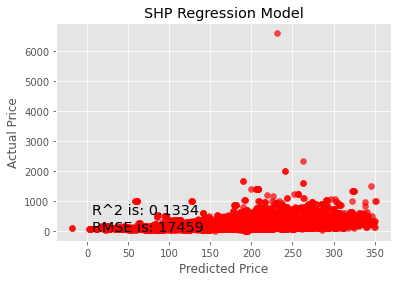

In [ ]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

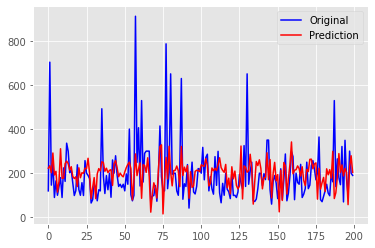

Bondad del ajuste en Train:	0.1095280691783459
Bondad del ajuste en Test:	0.1334099073047258


In [ ]:

from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train,y_train)

Y_predict = model.predict(X_test)
plt.plot(np.array(y_test)[:200],'b')
plt.plot(val_preds_hpm_reg[:200],'r')
plt.legend(['Original', 'Prediction'])
plt.show()

print("Bondad del ajuste en Train:\t{}".format(model.score(X_train,y_train)))

print("Bondad del ajuste en Test:\t{}".format(model.score(X_test,y_test)))


Si nuestros valores predichos fueran idénticos a los valores reales, este gráfico sería la línea recta `y = x` porque cada valor predicho x sería igual a cada valor real y. Vemos que nuestro modelo está lejos de alcanzarlo.

##### Mejorando el modelo

Podemos intentar usar la Ridge Regularization para disminuir la influencia de características menos importantes. La regularización de ridges es un proceso que reduce los coeficientes de regresión de las características menos importantes.

Creamos una nueva instancia del modelo. El modelo de regularización de Ridge toma un parámetro, alfa, que controla la fuerza de la regularización.

Experimentaremos recorriendo algunos valores diferentes de alfa y veremos cómo esto cambia nuestros resultados.

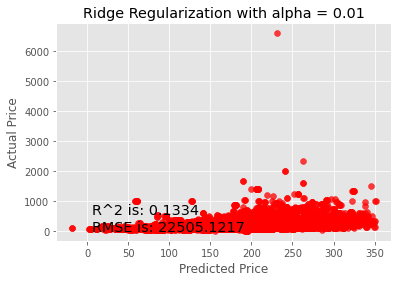

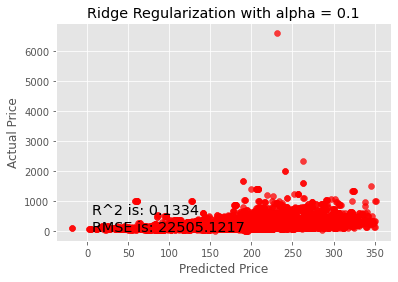

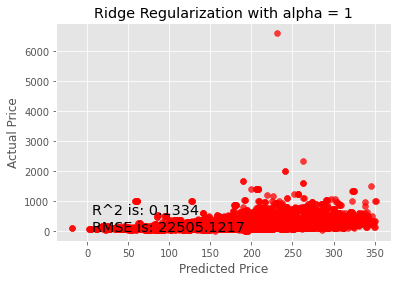

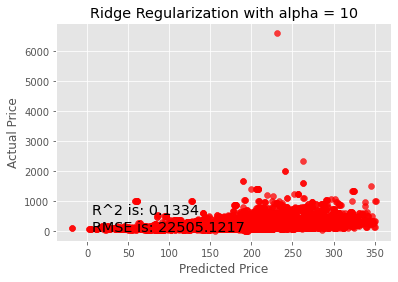

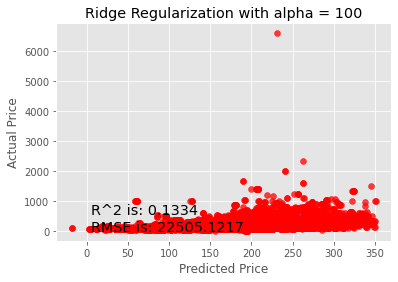

In [ ]:
lr = linear_model.LinearRegression()

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='r')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                   round(ridge_model.score(X_test, y_test), 4),
                    round(mean_squared_error(y_train, training_preds_hpm_reg),4))
    plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
    plt.show()

Conclusión: Los dos modelos tienen la misma performance y ajustar las alfas no ha mejorado nuestro modelo

#### Modelo 2:  Gradient boosted decision trees


El refuerzo es una técnica de conjunto donde se agregan nuevos modelos para corregir los errores cometidos por los modelos existentes. Los modelos se agregan secuencialmente hasta que no se puedan realizar más mejoras. Un ejemplo popular es el algoritmo AdaBoost que pondera los puntos de datos que son difíciles de predecir.

El aumento de gradiente es un enfoque donde se crean nuevos modelos que predicen los residuos o errores de modelos anteriores y luego se suman para hacer la predicción final. Se llama aumento de gradiente porque utiliza un algoritmo de descenso de gradiente para minimizar la pérdida al agregar nuevos modelos.

XGBoost (eXtreme Gradient Boosting) es una implementación de árboles de decisión potenciados por gradiente diseñados para la velocidad y el rendimiento. Es un algoritmo muy popular que recientemente ha dominado el aprendizaje automático aplicado para datos estructurados o tabulares.

Este enfoque admite problemas de modelado predictivo de regresión y clasificación. Para obtener más información, vea aquí para escuchar a Tianqi Chen, el creador de la biblioteca XGBoost.

Es muy probable que este modelo proporcione la mejor precisión posible y una medida de la importancia de la característica en comparación con nuestra regresión hedónica (aparte de los posibles pequeños aumentos de precisión de la sintonización de hiperparámetros) debido al rendimiento superior de XGBoost.

In [ ]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[22:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.1 minutes

Training MSE: 14594.0986
Validation MSE: 13226.3864

Training r2: 0.4225
Validation r2: 0.3435


**Esto significa que nuestras características explican aproximadamente el 34,35% de la varianza en nuestra variable objetivo.**

##### Importancia de la característica

Importancia de la característica
Además de su rendimiento superior, una ventaja de usar conjuntos de métodos de árbol de decisión como el aumento de gradiente es que pueden proporcionar automáticamente estimaciones de la importancia de las características de un modelo predictivo entrenado.

En general, la importancia proporciona una puntuación que indica cuán útil o valiosa fue cada característica en la construcción de los árboles de decisión potenciados dentro del modelo. Cuanto más se utiliza un atributo para tomar decisiones clave con árboles de decisión, mayor es su importancia relativa.

Esta importancia se calcula explícitamente para cada atributo en el conjunto de datos, lo que permite clasificar y comparar los atributos entre sí.

La importancia se calcula para un solo árbol de decisión por la cantidad que cada punto de división de atributo mejora la medida de rendimiento, ponderada por el número de observaciones de las que es responsable el nodo. La medida del rendimiento puede ser la pureza (índice de Gini) utilizada para seleccionar los puntos de división u otra función de error más específica.

Las características importantes se promedian en todos los árboles de decisión dentro del modelo.

In [ ]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(20)

,weight
host_name,0.214736
cluster,0.157637
room_type,0.154317
latitude,0.094896
availability_365,0.088957
number_of_reviews,0.053241
last_review,0.051475
longitude,0.048881
calculated_host_listings_count,0.047647
minimum_nights,0.035785


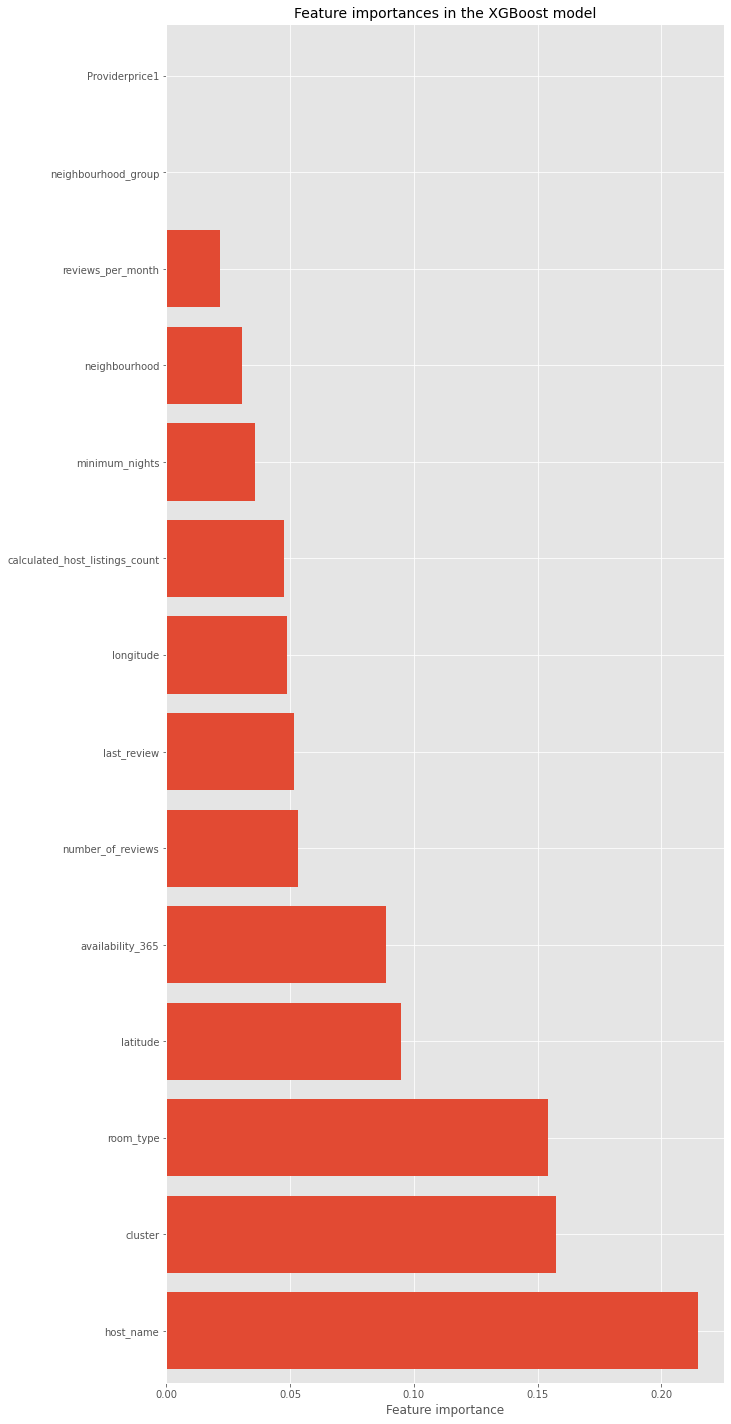

In [ ]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Las características de ubicación cuando son corregidas por la distancia de features es la más relevante en nuestro modelo, o sea, pertenecer a un determinado vecindario (cluster) aumenta el precio aunque el más relevante sea el host_name.
Una de las características interesantes es que el host_name es uno de las principales características determinantes del precio en nuestro modelo,  lo que no significa que un host que gestiona más propiedades dará como resultado tener precios más altos, y podría deberse a que los hosts experimentados establecen precios más altos. Además, podría ser que las grandes compañías de administración de Airbnb que tienen muchos listados tienden a administrar propiedades más caras que los anfitriones de listados únicos. El precio de los hoteles no ha sido relevante para el análisis al final.

#### Selección del modelo final

En general, el modelo XGBoost (Modelo 2) es el modelo preferido, que funciona mejor que los modelos de regresión hedónica espacial. Sin embargo el R**2 no es bueno, y, posiblemente podría mejorarse aún más con el ajuste de hiperparámetros.

### Conclusiones 

El modelo con mejor desempeño fue capaz de predecir el 34.35% de la variación en el precio. Lo que significa que todavía tenemos un 65,65% restante sin explicación. Esto podría deberse a varias otras características que no forman parte de nuestro conjunto de datos o la necesidad de analizar nuestras características más de cerca, o mismo combinar los datos de forma diferente, dado que tras mucha manipulación, no se ha cogido los vecindarios por asociación entre latitud y longitud o mismo hecho coincidir nombres de hoteles (html entrega II).

Por ejemplo, dada la importancia de las revisiones de los clientes de la lista para determinar el precio, tal vez una mejor comprensión de las revisiones podría mejorar la predicción. Mediante el Análisis de opiniones, se puede asignar una puntuación entre -1 (opinión muy negativa) y 1 (opinión muy positiva) a cada revisión por propiedad de listado. Los puntajes se promedian en todas las revisiones asociadas con ese listado y los puntajes finales se pueden incluir como una nueva característica en el modelo (consulte [aquí] (https://arxiv.org/pdf/1907.12665.pdf) para ver un ejemplo )

Otra sugerencia es la inclusión de la calidad de imagen como característica. Utilizando el análisis profundo de Diferencia en Diferencia y aprendizaje supervisado en un conjunto de datos de panel de Airbnb, los investigadores descubrieron que las unidades con fotos verificadas (tomadas por los fotógrafos de Airbnb) generan ingresos adicionales por año en promedio ([ver aquí] (https: // poseidon01. ssrn.com/delivery.php?ID=204024105119026094069105008103096093034021070051045032025117103105027080085099113011048103001010014121023024085079004082003114107082070089028074094097015117086091125049040024103012093025001119016069070080070120120094005077005088015116003064009008121126&EXT=pdf)).

Se notó que la cercanía con puntos de hoteles fue más importante que otras características de los hoteles.Para los listados esto es importante dado que los hosts podrían tener mayores benefícios cuando estén cerca de hoteles.